In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge , Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# 1. 전처리 및 EDA

## 1.1 Load Data

In [22]:
df_sales_train0 = pd.read_csv('../data/raw/sales_train.csv')
test = pd.read_csv('../data/raw/test.csv')
df_shops = pd.read_csv('../data/raw/shops.csv')
df_items = pd.read_csv('../data/raw/items.csv')
df_catog = pd.read_csv('../data/raw/item_categories.csv')
df = pd.read_csv('../data/raw/sample_submission.csv')
df_sales_train0.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### 총판매량 시각화

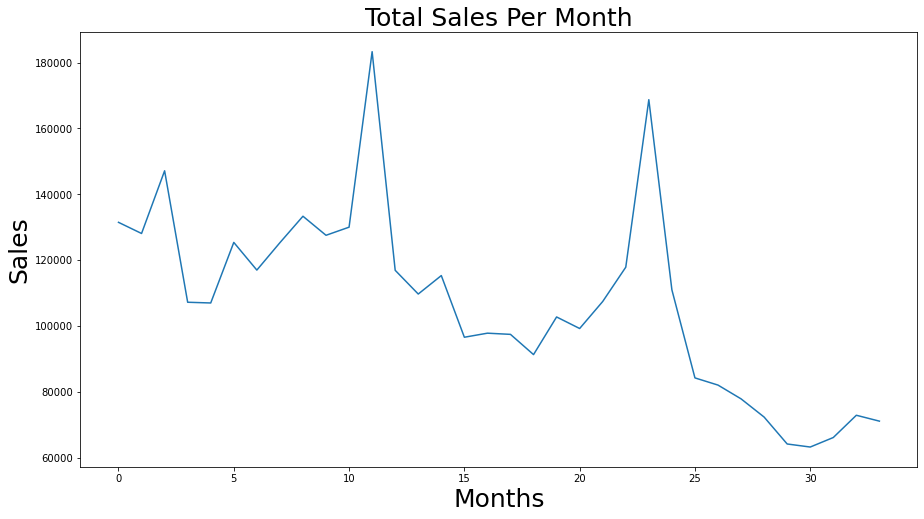

In [49]:
#this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

Z = df_sales_train0.groupby('date_block_num').agg({'item_cnt_day': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (15,8))
sns.lineplot(data=Z, x='date_block_num', y='item_cnt_day', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);

### 월별 물품 평균가
- 추측1. 판매종 고가취급품목 변환
- 추측2. 인플레이션 적용

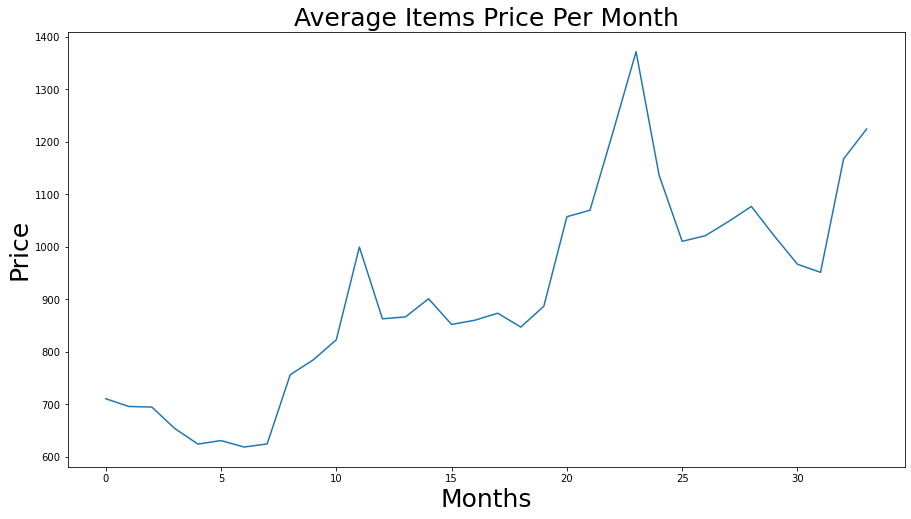

In [50]:
#also this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

price_per_month = df_sales_train0.groupby('date_block_num').agg({'item_price': 'mean'}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (15,8))
sns.lineplot(data=price_per_month, x='date_block_num', y='item_price', ax = ax, palette="BrBG")
plt.title('Average Items Price Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Price', fontsize=25);

## 1.2 데이터 전처리 : Feature 생성
- 생성과정 중간 예측대상인 데이터(test.csv) 또한 합하여 전처리 진행

### 1.2.1 월별, 매장별, 아이템별 총판매량 생성

In [101]:
from itertools import product
df_sales_train = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_sales_train0[df_sales_train0['date_block_num'] == i]
    df_sales_train.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
    
df_sales_train = pd.DataFrame(np.vstack(df_sales_train), columns=cols)

In [102]:
# shop_id, item_id 모든 조합 생성
df_sales_train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [103]:
# 일별 판매주문별 금액 계산
df_sales_train0['revenue'] = df_sales_train0['item_price'] *  df_sales_train0['item_cnt_day']
df_sales_train0.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [104]:
# 월 -  마트 - 아이템 단위 판매액 계산
agg = df_sales_train0.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
agg.columns = ['item_cnt_month']
agg.reset_index(inplace=True)
merge1 = pd.merge(df_sales_train, agg, on=cols, how='left')

In [105]:
merge1.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN


#### Test 데이터셋 전처리

In [106]:
#test['date_block_num'] = 34

test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

#### sales 데이터 : Test 정보 기준 Shop, Item 필터링

In [107]:
print('before :', merge1.shape)
# Only shops that exist in test set.
merge1 = merge1[merge1['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
merge1 = merge1[merge1['item_id'].isin(test_item_ids)]
merge1.reset_index(inplace=True, drop=True)
print('after :,', merge1.shape)

before : (10913850, 4)
after :, (2774438, 4)


#### Merge : sales, shop, item, category, test 데이터. + fillna

In [108]:
merge1 = pd.concat([merge1, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merge1.fillna(0, inplace=True)

In [109]:
merge1 = pd.merge(merge1, df_shops, on=['shop_id'], how='left')
merge1 = pd.merge(merge1, df_items, on=['item_id'], how='left')
merge1 = pd.merge(merge1, df_catog, on=['item_category_id'], how='left')

In [110]:
merge1.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,item_name,item_category_id,item_category_name
0,0,59,22154,1.0,0.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2574,2.0,0.0,"Ярославль ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2,0,59,2607,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства
3,0,59,2614,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства
4,0,59,2808,15.0,0.0,"Ярославль ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания


#### Shop 중복값 처리
- 동일 ID 부여

In [111]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [112]:
merge1.loc[merge1.shop_id == 0, 'shop_id'] = 57
merge1.loc[merge1.shop_id == 1, 'shop_id'] = 58
merge1.loc[merge1.shop_id == 10, 'shop_id'] = 11

#### 판매량 Lag 생성
- 1, 2, 3, 6, 12개월 간격
- 문제점 : 초기데이터에 Null 발생 

In [113]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [114]:
merge1 = lag_feature(merge1, [1,2,3,6,12], 'item_cnt_month')  # Create months lags

In [115]:
merge1.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,59,22154,1.0,0.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,NaN,NaN,NaN,NaN,NaN
1,0,59,2574,2.0,0.0,"Ярославль ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN
2,0,59,2607,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN
3,0,59,2614,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN
4,0,59,2808,15.0,0.0,"Ярославль ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,NaN,NaN,NaN,NaN,NaN


### 1.2.2 소비자물가지수(CPI, Consumer Price Index) 생성
- 2013.1-2015.10 러시아 소비자물가지수 반영
- lag만큼 적용

In [116]:
CPI_inflation = [0.97,0.56,0.34,0.51,0.66,0.42,0.82,0.14,0.21,0.57,0.57,0.50,
                 0.59,0.70,1.02,0.90,0.90,0.62,0.49,0.24,0.65,0.82,1.28,2.62,
                 3.85,2.22,1.21,0.46,0.35,0.19,0.80,0.35,0.57,0.74,0.75]
merge1['CPI_inflation'] = 0
for i, value in enumerate(CPI_inflation):
    merge1.loc[merge1.date_block_num==i, 'CPI_inflation'] = value
    
merge1 = lag_feature(merge1, [1,2,3,6,12], 'CPI_inflation')
merge1.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,CPI_inflation,CPI_inflation_lag_1,CPI_inflation_lag_2,CPI_inflation_lag_3,CPI_inflation_lag_6,CPI_inflation_lag_12
0,0,59,22154,1.0,0.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,NaN
1,0,59,2574,2.0,0.0,"Ярославль ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,NaN
2,0,59,2607,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,NaN
3,0,59,2614,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,NaN
4,0,59,2808,15.0,0.0,"Ярославль ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN,NaN,NaN,NaN


### 1.2.3 월별 전국평균 판매량 생성 
- lag : 1

In [117]:
agg = merge1.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num'], how='left')
merge1 = lag_feature(merge1, [1], 'date_avg_item_cnt')
# merge1.drop(['date_avg_item_cnt'], axis=1, inplace=True)

### 1.2.4 월별, 아이템별 전국평균 판매량 생성
- lag 1,2,3,6,12

In [118]:
agg = merge1.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_item_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
merge1 = lag_feature(merge1, [1,2,3,6,12], 'date_item_avg_item_cnt')
# merge1.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

### 1.2.5 아이템별 평균판매가 생성

In [119]:
agg =df_sales_train0.groupby(['item_id']).agg({'item_price': ['mean']})
agg.columns = ['item_avg_item_price']
agg.reset_index(inplace=True)
merge1 = pd.merge(merge1, agg, on=['item_id'], how='left')

### 1.2.6. 월별, 아이템별 평균판매가 생성
- lag 1,2,3,4,5,6

In [120]:
agg = df_sales_train0.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
agg.columns = ['date_item_avg_item_price']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
lags = [1,2,3,4,5,6]
merge1 = lag_feature(merge1, lags, 'date_item_avg_item_price')

In [121]:
merge1

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,59,22154,1.0,0.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,NaN,...,NaN,NaN,702.932203,999.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2574,2.0,0.0,"Ярославль ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,NaN,...,NaN,NaN,401.398686,392.986538,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2607,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,NaN,...,NaN,NaN,292.472832,261.896552,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2614,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства,NaN,...,NaN,NaN,296.998860,291.736842,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2808,15.0,0.0,"Ярославль ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,NaN,...,NaN,NaN,999.583758,981.221243,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988633,34,45,18454,0.0,214195.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,Музыка - CD локального производства,1.0,...,0.585366,NaN,188.681084,NaN,99.0,99.000000,99.000000,99.0,98.947368,199.000000
2988634,34,45,16188,0.0,214196.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры,0.0,...,NaN,NaN,1256.975000,NaN,1359.0,1222.966667,NaN,NaN,NaN,NaN
2988635,34,45,15757,0.0,214197.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства,0.0,...,0.243902,0.170732,198.113208,NaN,229.0,229.000000,229.000000,229.0,229.000000,208.090909
2988636,34,45,19648,0.0,214198.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD,0.0,...,0.097561,NaN,98.096296,NaN,89.1,99.000000,94.857143,99.0,99.000000,99.000000


## 1.3 데이터 전처리 : Fill missing value
- lag에 결측부분을 채움.

In [122]:
merge1.isnull().sum().sum()

19639133

In [123]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            elif('CPI_inflation' in col):
                df[col].fillna(0, inplace=True)        
    return df

In [124]:
merge1 = fill_na(merge1)
merge1.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,59,22154,1.0,0.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,0.0,...,0.0,0.0,702.932203,999.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2574,2.0,0.0,"Ярославль ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,0.0,...,0.0,0.0,401.398686,392.986538,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2607,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,0.0,...,0.0,0.0,292.472832,261.896552,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2614,0.0,0.0,"Ярославль ТЦ ""Альтаир""",DEPECHE MODE Violator,55,Музыка - CD локального производства,0.0,...,0.0,0.0,296.998860,291.736842,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2808,15.0,0.0,"Ярославль ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,0.0,...,0.0,0.0,999.583758,981.221243,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
merge1.isnull().sum().sum()

5053583